In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(os.getcwd())
from pathlib import Path
# folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
folder = Path(r'../../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

B:\GitRepos\onhm-fetcher-parser\notebooks\final_notebooks
..\..\Data
       LAYER    POI_ID                                           geometry  \
0        NaN   7733855  POLYGON ((-73.37148 41.11233, -73.37151 41.112...   
1        NaN   7733919  POLYGON ((-73.38532 41.13467, -73.38566 41.134...   
2        NaN   7732571  POLYGON ((-73.41947 41.16068, -73.41955 41.160...   
3        NaN   7732387  POLYGON ((-73.41097 41.15833, -73.41105 41.158...   
4        NaN   7733327  MULTIPOLYGON (((-73.28636 41.12781, -73.28645 ...   
...      ...       ...                                                ...   
109946   NaN   4439814  POLYGON ((-123.68276 41.59421, -123.68266 41.5...   
109947   NaN   2551733  MULTIPOLYGON (((-121.32645 42.31952, -121.3268...   
109948   NaN   2551733  POLYGON ((-121.14944 42.23414, -121.14935 42.2...   
109949   NaN  24081601  POLYGON ((-121.44144 42.80623, -121.44211 42.8...   
109950   NaN  24081601  MULTIPOLYGON (((-121.35190 42.77765, -121.3522...   

      

C:\Users\rmcd\anaconda3\envs\ofp_env_upd\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [4]:
import requests
from requests.exceptions import HTTPError

# delete existing file if it exists
exists = os.path.isfile(r'../../Data/test3.nc')
if exists:
#     ds.close()
    os.remove(r'../../Data/test3.nc')
    print('removed existing file')

# # Url for non-aggragated
# url = r'http://thredds.northwestknowledge.net:8080/thredds/ncss/MET/tmmn/tmmn_2019.nc'
# payload={'var': 'air_temperature',
#         'north': '49.4000',
#         'west': '-124.7666',
#         'east': '-67.0583',
#         'south': '25.0666',
#         'horizStride': '1',
#         'time_start': '2018-12-31T00:00:00Z',
#         'time_end': '2018-12-31T00:00:00Z',
#         'timeStride': '1',
#         'accept': 'netcdf4'}
# Note: when using the non-aggragated server, asking for dates in previous year fails.  Indicates
# that using the aggragated server would be the way to go when traversing a new calander year.
# http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-01-01T00%3A00%3A00Z&time_end=2019-01-01T00%3A00%3A00Z&timeStride=1&accept=netcdf
# Url for aggragated
url2 = 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc'
payload2={'var': 'daily_maximum_temperature',
        'disableLLSubset': 'on',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': '2018-12-31T00:00:00Z',
        'time_end': '2018-12-31T00:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf'}
# print(url)
try:
#     myfile = requests.get(url, params=payload)
    myfile = requests.get(url2, params=payload2)
    myfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Python 3.6
except Exception as err:
    print(f'Other error occurred: {err}')  # Python 3.6
else:
    print('Success!')
#     print(myfile.headers)
    print(myfile.url)
        
with open(r'../../Data/test3.nc', 'wb') as fh:
    fh.write(myfile.content)
    fh.close()

ds = xr.open_dataset(r'../../Data/test3.nc')
print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
# datahandle=ds['air_temperature'] # for non aggragated download
datahandle=ds['daily_maximum_temperature'] # for aggragated download
# crshandle=ds['crs']
# print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
# print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

removed existing file
Success!
http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00%3A00%3A00Z&time_end=2018-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf
<xarray.Dataset>
Dimensions:                    (day: 1, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2018-12-31
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -1

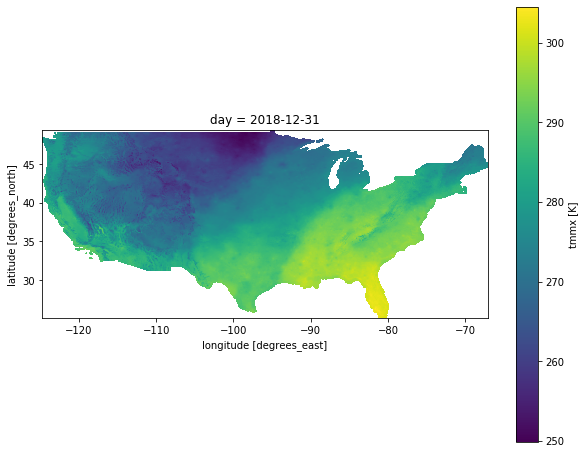

In [8]:
tmax = ds.daily_maximum_temperature.isel(day=[0])
# p = tmax.plot(col = 'time', aspect = ds.dims['x']/ds.dims['y'], size = 2)
p = tmax.plot()
p.axes.set_aspect('equal')
plt.show()

   grid_ids  hru_id_nat         w
0    278433           1  0.000120
1    277046           1  0.031155
2    277047           1  0.901587
3    277048           1  0.046570
4    275661           1  0.020568
[nan nan nan ... nan nan nan]
109951 109951
min/max -23.600006103515625 30.34247263281884


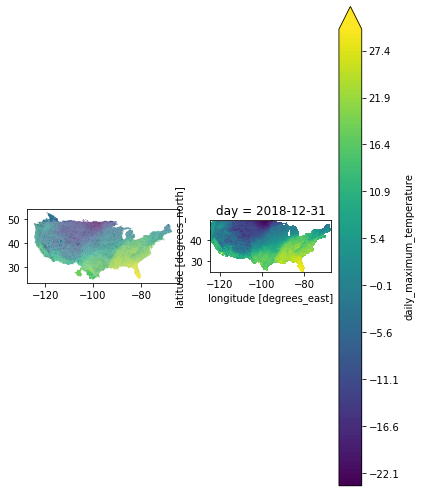

In [18]:

from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../../Data/tmp_weights_hru_v1_0.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby('hru_id_nat')
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row['hru_id_nat'])
#         td[index] = np_get_wval2(weight_id_rows, ndata) - 273.5
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, index+1) - 273.5)
    except KeyError:
        td[index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

f, ax = plt.subplots(1, 2, figsize=(6,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[0].set_aspect('equal', 'box')
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
p=temp.plot(ax=ax[1], levels=lvs, cmap='viridis')
ax[1].set_aspect('equal','box')


In [19]:
import cartopy.crs as ccrs

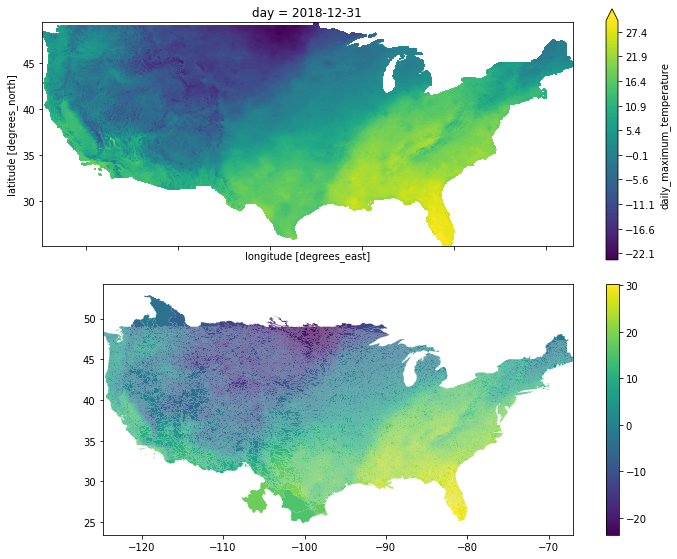

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f, ax = plt.subplots(2, 1, sharex=True)

lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)

p=temp.plot(ax=ax[0], levels=lvs, cmap='viridis')
ax[0].set_aspect('equal', 'box')

g = gdf.plot(ax=ax[1], column = 'tmax',linewidth=0., edgecolor='white', legend=True)
temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[1].set_aspect('equal', 'box')


plt.tight_layout()
plt.show()

In [37]:
print(wght_UofI.head(6))

   grid_ids  hru_id_nat         w
0    278433           1  0.000120
1    277046           1  0.031155
2    277047           1  0.901587
3    277048           1  0.046570
4    275661           1  0.020568
5    277046           2  0.131723
